# Telco Customer Churn - Exploratory Data Analysis

This notebook explores churn patterns in the Telco dataset, with a focus on data quality,
summary statistics, and churn differences across key customer segments.


## Goals
- Quantify overall churn and the target distribution
- Surface churn differences by service, contract, and payment categories
- Compare numeric drivers such as tenure and charges


## Setup

In [22]:
from pathlib import Path
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

warnings.filterwarnings("ignore")

pd.set_option("display.max_columns", 50)
pd.set_option("display.width", 120)

plt.rcParams.update({
    "figure.figsize": (10, 5),
    "axes.grid": True,
    "axes.titlesize": 12,
    "axes.labelsize": 10,
})

DATA_PATH = Path("../data/WA_Fn-UseC_-Telco-Customer-Churn.csv")
OUT_DIR = Path("../outputs")
FIG_DIR = OUT_DIR / "figures"
TAB_DIR = OUT_DIR / "tables"
FIG_DIR.mkdir(parents=True, exist_ok=True)
TAB_DIR.mkdir(parents=True, exist_ok=True)


## Load data

In [23]:
df = pd.read_csv(DATA_PATH)
print(f"Shape: {df.shape}")
display(df.head())
df.info()


Shape: (7043, 21)


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


<class 'pandas.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   str    
 1   gender            7043 non-null   str    
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   str    
 4   Dependents        7043 non-null   str    
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   str    
 7   MultipleLines     7043 non-null   str    
 8   InternetService   7043 non-null   str    
 9   OnlineSecurity    7043 non-null   str    
 10  OnlineBackup      7043 non-null   str    
 11  DeviceProtection  7043 non-null   str    
 12  TechSupport       7043 non-null   str    
 13  StreamingTV       7043 non-null   str    
 14  StreamingMovies   7043 non-null   str    
 15  Contract          7043 non-null   str    
 16  PaperlessBilling  7043 non-null   str    
 17  Paymen

## Data quality checks

In [24]:
dup_count = df.duplicated().sum()
print("Duplicate rows:", dup_count)

missing = df.isna().sum().sort_values(ascending=False)
missing = missing[missing > 0]
print("Missing values:")
display(missing)

cat_cols = df.select_dtypes(include=["object"]).columns.tolist()
cat_summary = pd.DataFrame({"column": cat_cols, "nunique": [df[c].nunique() for c in cat_cols]})
display(cat_summary.sort_values("nunique", ascending=False))


Duplicate rows: 0
Missing values:


Series([], dtype: int64)

,column,nunique
0,customerID,7043
16,TotalCharges,6531
15,PaymentMethod,4
13,Contract,3
5,MultipleLines,3
8,OnlineBackup,3
9,DeviceProtection,3
10,TechSupport,3
7,OnlineSecurity,3
6,InternetService,3


## Cleaning and standardization

In [25]:
df_clean = df.copy()

if "TotalCharges" in df_clean.columns:
    df_clean["TotalCharges"] = pd.to_numeric(df_clean["TotalCharges"], errors="coerce")
    missing_tc = df_clean["TotalCharges"].isna().sum()
    print("Missing TotalCharges after conversion:", missing_tc)
    df_clean["TotalCharges"] = df_clean["TotalCharges"].fillna(0)

if "SeniorCitizen" in df_clean.columns:
    df_clean["SeniorCitizen"] = df_clean["SeniorCitizen"].map({0: "No", 1: "Yes"}).astype("category")

if "Churn" in df_clean.columns:
    df_clean["Churn"] = df_clean["Churn"].astype(str).str.strip().astype("category")

if "customerID" in df_clean.columns:
    df_clean = df_clean.drop(columns=["customerID"])

df_clean.info()


Missing TotalCharges after conversion: 11
<class 'pandas.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   gender            7043 non-null   str     
 1   SeniorCitizen     7043 non-null   category
 2   Partner           7043 non-null   str     
 3   Dependents        7043 non-null   str     
 4   tenure            7043 non-null   int64   
 5   PhoneService      7043 non-null   str     
 6   MultipleLines     7043 non-null   str     
 7   InternetService   7043 non-null   str     
 8   OnlineSecurity    7043 non-null   str     
 9   OnlineBackup      7043 non-null   str     
 10  DeviceProtection  7043 non-null   str     
 11  TechSupport       7043 non-null   str     
 12  StreamingTV       7043 non-null   str     
 13  StreamingMovies   7043 non-null   str     
 14  Contract          7043 non-null   str     
 15  PaperlessBilling  7043 non-null   str    

## PCA

In [ ]:
from sklearn.preprocessing import StandardScaler
scale = StandardScaler()


In [46]:
df_clean_numerical = df_clean[["tenure","MonthlyCharges","TotalCharges"]].copy()
df_clean_numerical.head()

,tenure,MonthlyCharges,TotalCharges
0,1,29.85,29.85
1,34,56.95,1889.50
2,2,53.85,108.15
3,45,42.30,1840.75
4,2,70.70,151.65


In [ ]:
df_scaled_array=scale.fit_transform(df_clean_numerical)
df_scaled_df = pd.DataFrame(df_scaled_array, columns=df_clean_numerical.columns, index=df_clean_numerical.index)
df_scaled_df.describe()


,tenure,MonthlyCharges,TotalCharges
count,7.043000e+03,7.043000e+03,7.043000e+03
mean,-2.421273e-17,-6.406285e-17,-3.783239e-17
std,1.000071e+00,1.000071e+00,1.000071e+00
min,-1.318165e+00,-1.545860e+00,-1.005780e+00
25%,-9.516817e-01,-9.725399e-01,-8.299464e-01
50%,-1.372744e-01,1.857327e-01,-3.905282e-01
75%,9.214551e-01,8.338335e-01,6.648034e-01
max,1.613701e+00,1.794352e+00,2.825806e+00


In [ ]:
from sklearn.decomposition import PCA

pca= PCA()
pca.fit(df_scaled_array)

explained_variance_ratio = pca.explained_variance_ratio_

# Get the cumulative explained variance
cumulative_explained_variance = np.cumsum(explained_variance_ratio)



10

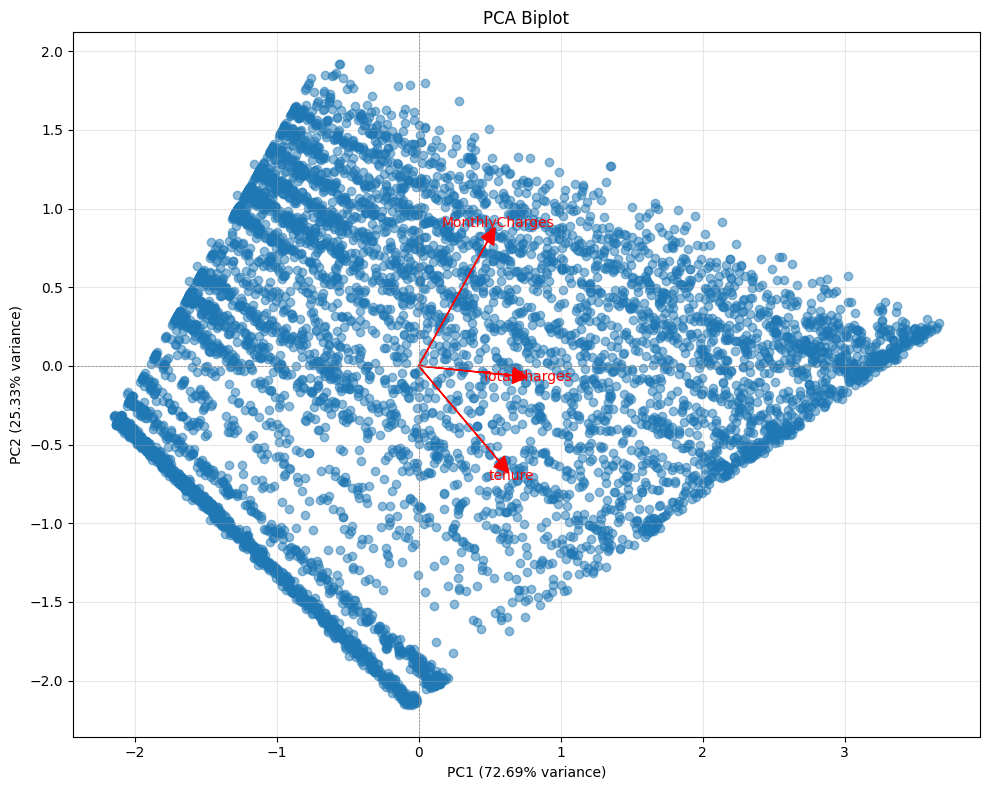

In [68]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
scores = pca.fit_transform(df_scaled_df)  # or df_scaled_array

# Get loadings (how original variables relate to PCs)
loadings = pca.components_.T

# Create biplot
fig, ax = plt.subplots(figsize=(10, 8))

# Plot scores (data points)
ax.scatter(scores[:, 0], scores[:, 1], alpha=0.5)

# Plot loadings (arrows for each variable)
for i, var in enumerate(df_scaled_df.columns):
    ax.arrow(0, 0, loadings[i, 0], loadings[i, 1], 
             head_width=0.1, head_length=0.1, 
             fc='red', ec='red')
    ax.text(loadings[i, 0] * 1.15, loadings[i, 1] * 1.15, 
            var, color='red', ha='center', va='center', fontsize=10)

ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)')
ax.set_title('PCA Biplot')
ax.axhline(0, color='gray', linewidth=0.5, linestyle='--')
ax.axvline(0, color='gray', linewidth=0.5, linestyle='--')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


[1 2 3]


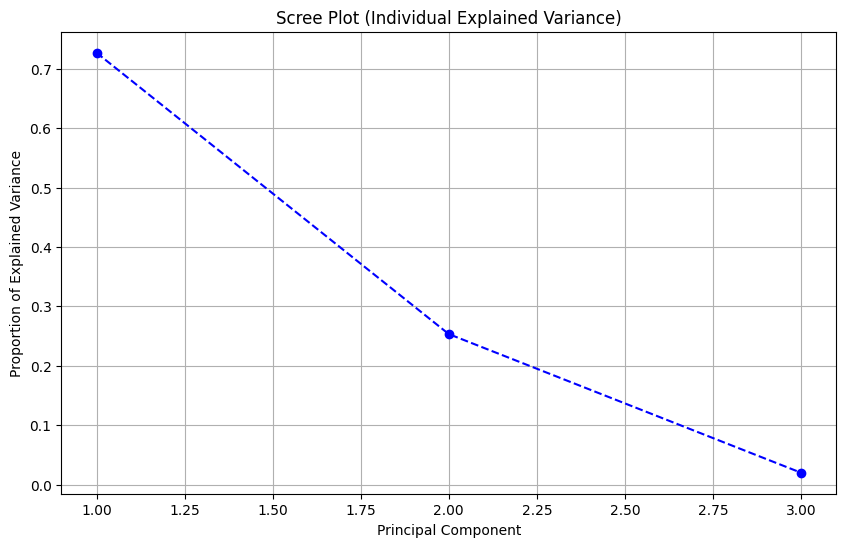

In [ ]:
# Generate component numbers (PC1, PC2, etc.)
pc_numbers = np.arange(len(explained_variance_ratio)) + 1

plt.figure(figsize=(10, 6))
plt.plot(pc_numbers, explained_variance_ratio, marker='o', linestyle='--', color='b')
plt.title('Scree Plot (Individual Explained Variance)')
plt.xlabel('Principal Component')
plt.ylabel('Proportion of Explained Variance')
plt.grid(True)
plt.show()


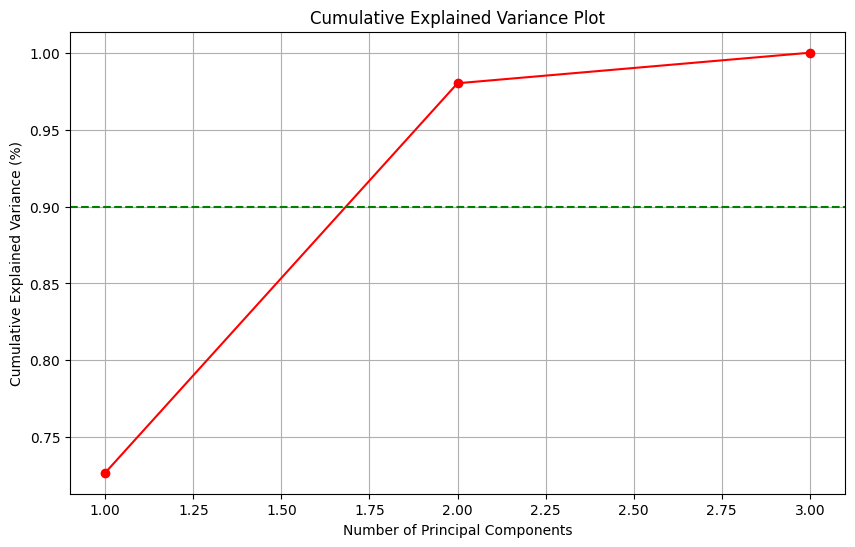

In [66]:
plt.figure(figsize=(10, 6))
plt.plot(pc_numbers, cumulative_explained_variance, marker='o', linestyle='-', color='r')
plt.title('Cumulative Explained Variance Plot')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance (%)')
plt.axhline(y=0.90, color='g', linestyle='--') # Optional: Add a threshold line
plt.grid(True)
plt.show()


## Target distribution

,count,rate
Churn,,
No,5174,0.73463
Yes,1869,0.26537


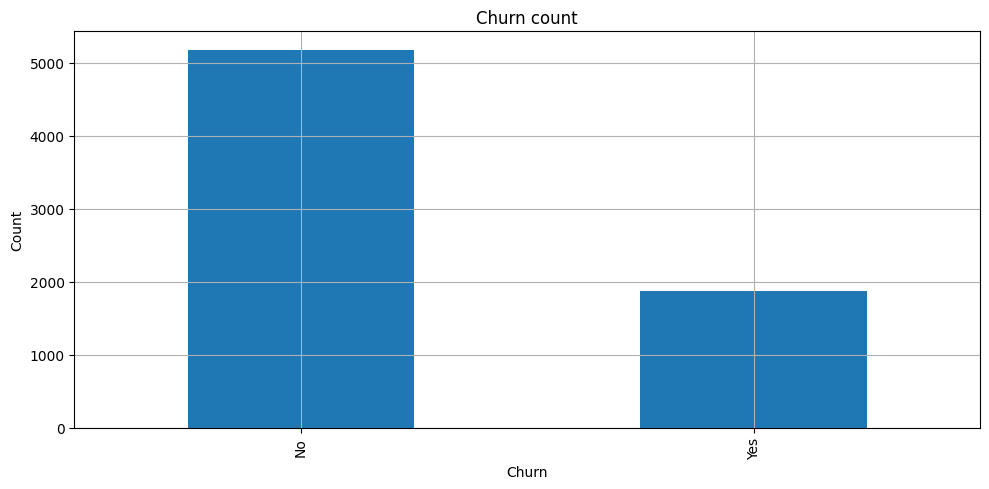

Churn rate (Yes): 0.265


In [26]:
churn_counts = df_clean["Churn"].value_counts(dropna=False)
churn_rate = (churn_counts / churn_counts.sum()).rename("rate")
display(pd.concat([churn_counts.rename("count"), churn_rate], axis=1))

ax = churn_counts.plot(kind="bar")
ax.set_title("Churn count")
ax.set_xlabel("Churn")
ax.set_ylabel("Count")
plt.tight_layout()
plt.savefig(FIG_DIR / "churn_count.png", dpi=200)
plt.show()

print(f"Churn rate (Yes): {churn_rate.get('Yes', np.nan):.3f}")


## Univariate numeric distributions

Numeric columns: ['tenure', 'MonthlyCharges', 'TotalCharges']


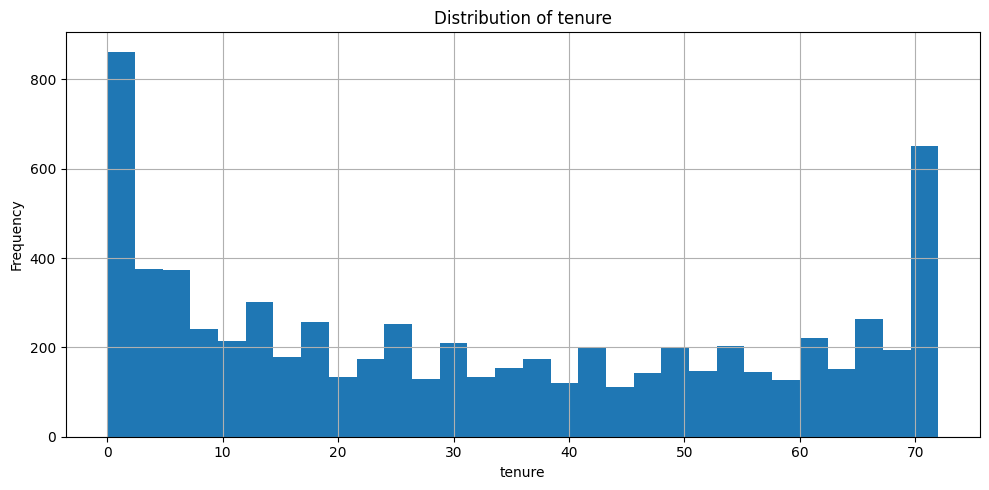

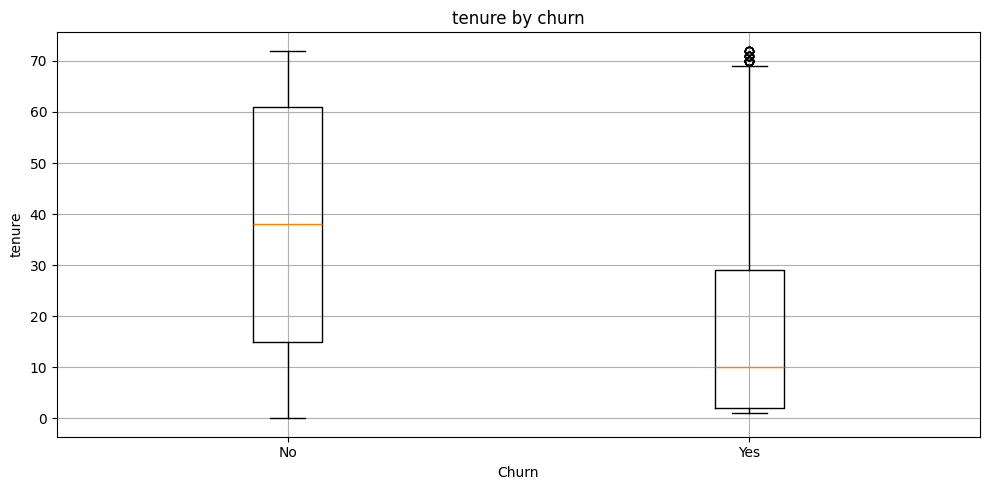

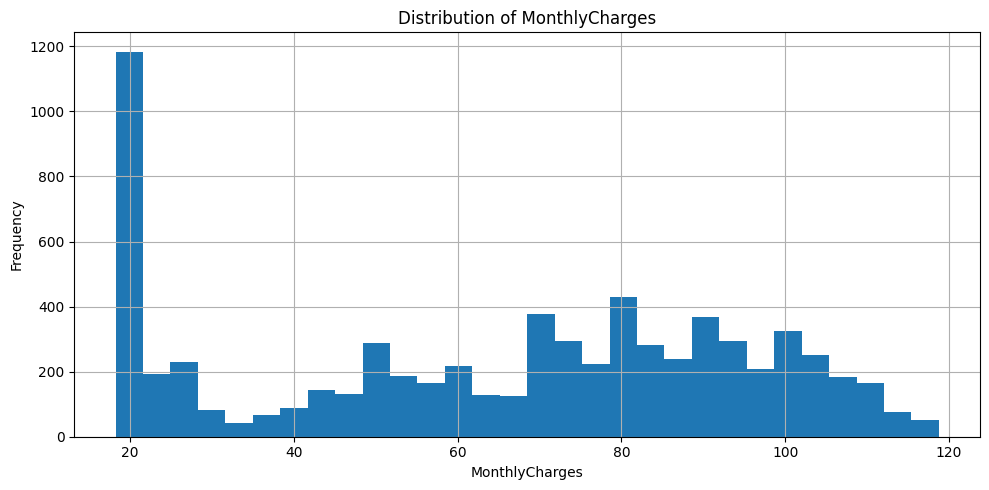

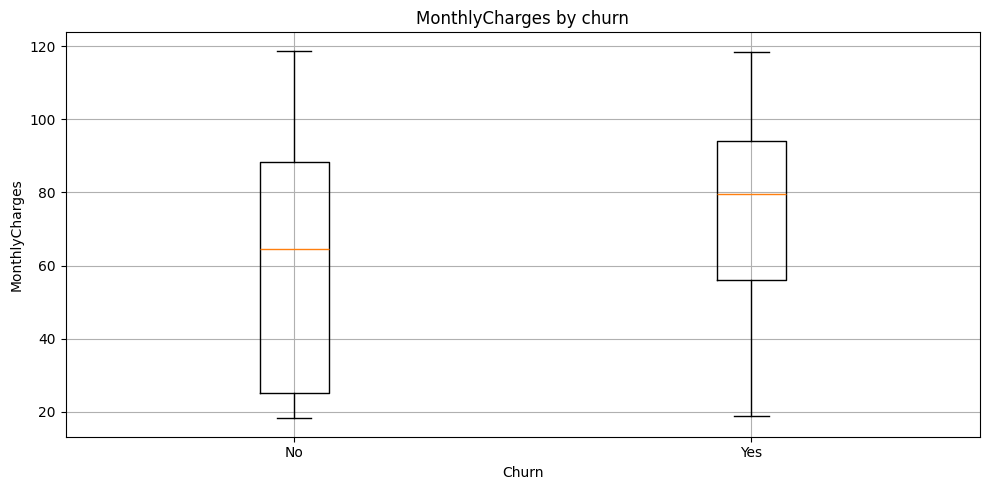

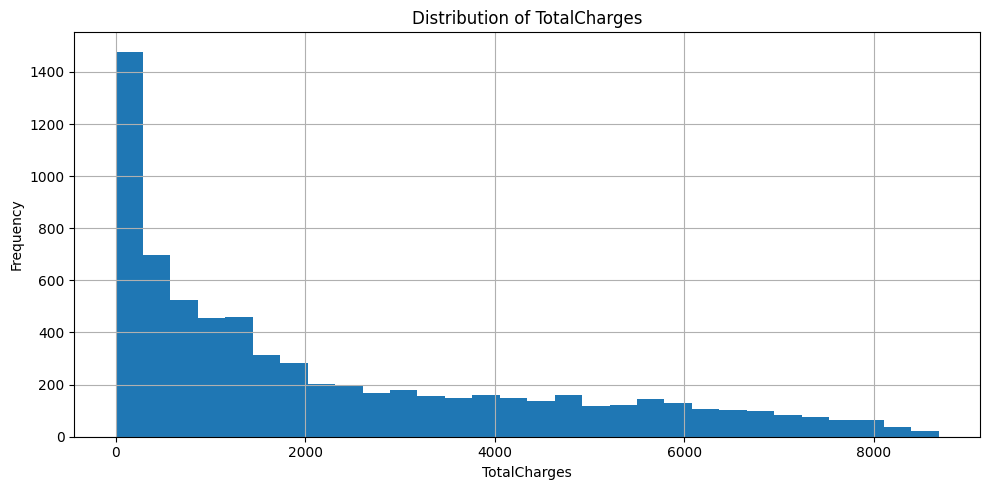

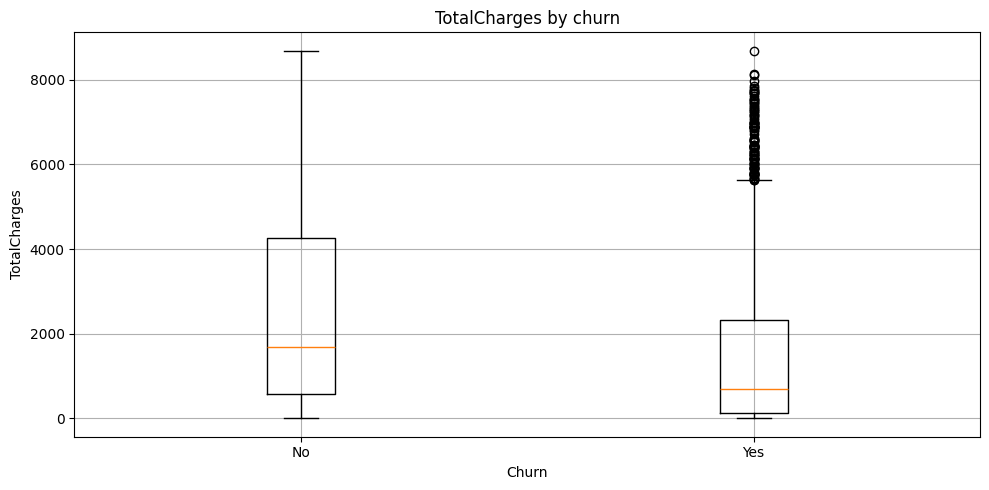

In [18]:
num_cols = df_clean.select_dtypes(include=[np.number]).columns.tolist()
print("Numeric columns:", num_cols)

def plot_hist(series, title, fname):
    s = series.dropna()
    plt.figure()
    plt.hist(s, bins=30)
    plt.title(title)
    plt.xlabel(series.name)
    plt.ylabel("Frequency")
    plt.tight_layout()
    plt.savefig(FIG_DIR / fname, dpi=200)
    plt.show()

def plot_box_by_churn(col, fname):
    yes = df_clean.loc[df_clean["Churn"] == "Yes", col].dropna()
    no = df_clean.loc[df_clean["Churn"] == "No", col].dropna()

    plt.figure()
    plt.boxplot([no, yes], labels=["No", "Yes"])
    plt.title(f"{col} by churn")
    plt.xlabel("Churn")
    plt.ylabel(col)
    plt.tight_layout()
    plt.savefig(FIG_DIR / fname, dpi=200)
    plt.show()

for c in [x for x in ["tenure", "MonthlyCharges", "TotalCharges"] if x in df_clean.columns]:
    plot_hist(df_clean[c], f"Distribution of {c}", f"hist_{c}.png")
    plot_box_by_churn(c, f"box_{c}_by_churn.png")


## Churn rate by category

,Contract,rate,count
1,Month-to-month,0.427097,3875
3,One year,0.112695,1473
5,Two year,0.028319,1695


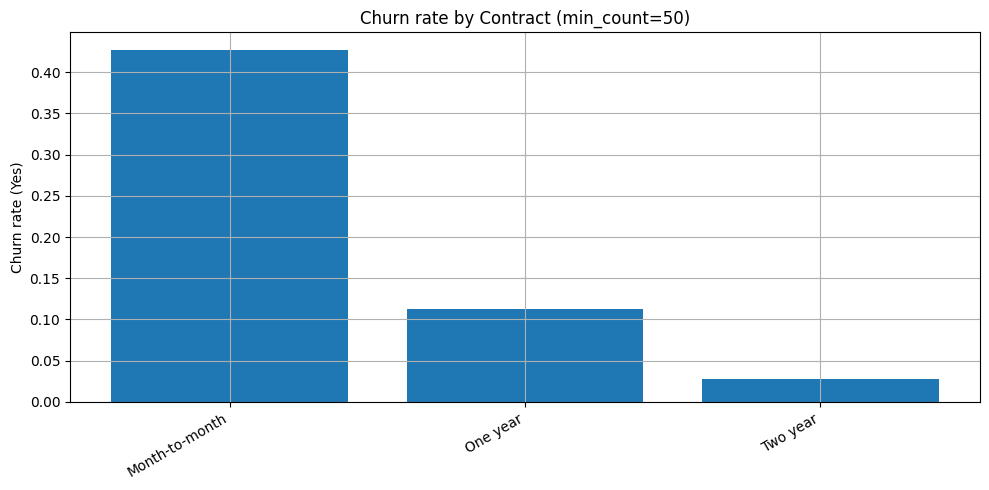

,PaymentMethod,rate,count
5,Electronic check,0.452854,2365
7,Mailed check,0.191067,1612
1,Bank transfer (automatic),0.167098,1544
3,Credit card (automatic),0.152431,1522


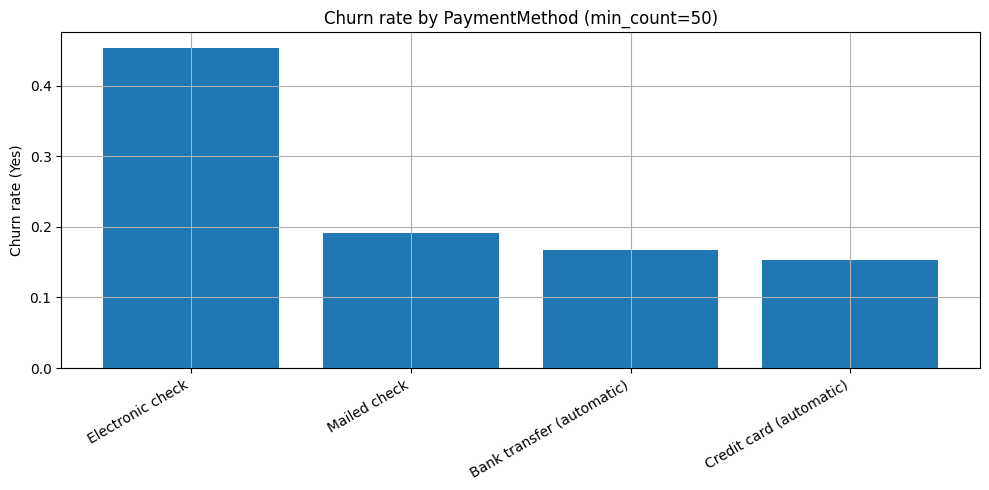

,InternetService,rate,count
3,Fiber optic,0.418928,3096
1,DSL,0.189591,2421
5,No,0.074050,1526


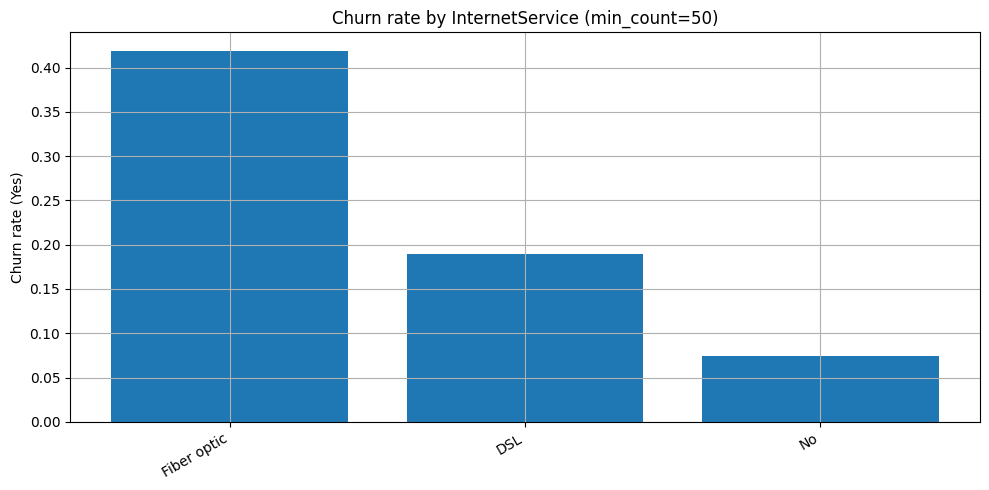

,TechSupport,rate,count
1,No,0.416355,3473
5,Yes,0.151663,2044
3,No internet service,0.074050,1526


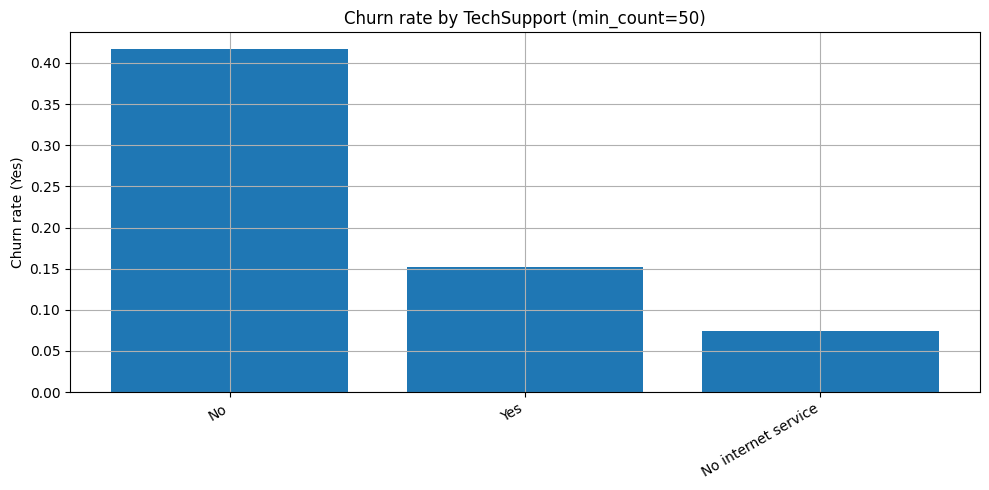

,OnlineSecurity,rate,count
1,No,0.417667,3498
5,Yes,0.146112,2019
3,No internet service,0.074050,1526


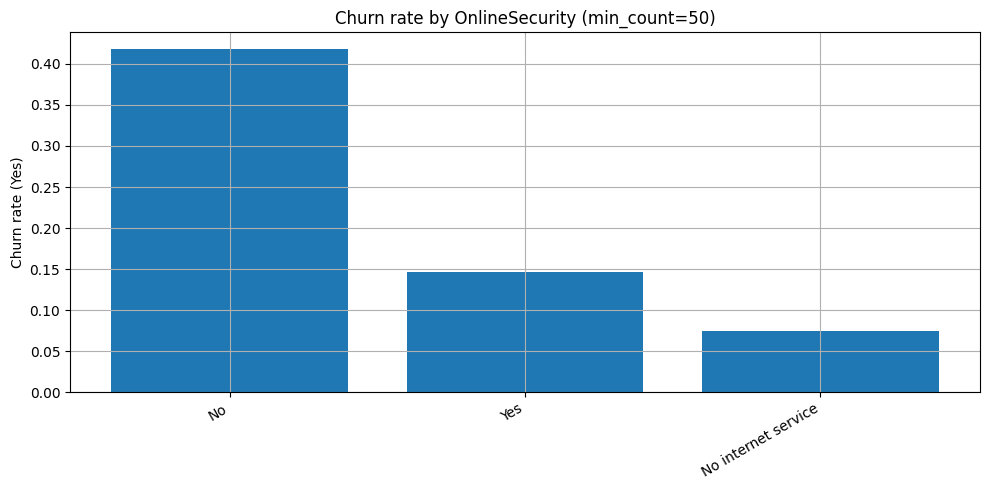

In [19]:
def churn_rate_by_category(col, min_count=50):
    tmp = (
        df_clean.groupby(col)["Churn"]
        .value_counts(normalize=True)
        .rename("rate")
        .reset_index()
    )
    tmp_yes = tmp[tmp["Churn"] == "Yes"].drop(columns=["Churn"])

    counts = df_clean[col].value_counts().rename("count")
    out = tmp_yes.merge(counts, left_on=col, right_index=True)
    out = out[out["count"] >= min_count].sort_values("rate", ascending=False)
    return out

def plot_churn_rate_by_category(col, fname, min_count=50):
    rates = churn_rate_by_category(col, min_count=min_count)
    if rates.empty:
        print(f"Skipping {col}: no categories meet min_count={min_count}")
        return

    plt.figure(figsize=(10, 5))
    plt.bar(rates[col].astype(str), rates["rate"])
    plt.title(f"Churn rate by {col} (min_count={min_count})")
    plt.ylabel("Churn rate (Yes)")
    plt.xticks(rotation=30, ha="right")
    plt.tight_layout()
    plt.savefig(FIG_DIR / fname, dpi=200)
    plt.show()

priority_cats = [
    c for c in ["Contract", "PaymentMethod", "InternetService", "TechSupport", "OnlineSecurity"]
    if c in df_clean.columns
]
for c in priority_cats:
    display(churn_rate_by_category(c, min_count=50).head(20))
    plot_churn_rate_by_category(c, f"churn_rate_by_{c}.png", min_count=50)


## Statistical tests on numeric drivers

In [20]:
def numeric_tests(col):
    yes = df_clean.loc[df_clean["Churn"] == "Yes", col].dropna()
    no = df_clean.loc[df_clean["Churn"] == "No", col].dropna()

    t_stat, t_p = stats.ttest_ind(yes, no, equal_var=False)
    u_stat, u_p = stats.mannwhitneyu(yes, no, alternative="two-sided")

    mean_yes, mean_no = yes.mean(), no.mean()
    sd_yes, sd_no = yes.std(ddof=1), no.std(ddof=1)
    n_yes, n_no = len(yes), len(no)
    pooled_sd = (
        np.sqrt(((n_yes - 1) * sd_yes ** 2 + (n_no - 1) * sd_no ** 2) / (n_yes + n_no - 2))
        if (n_yes + n_no - 2) > 0
        else np.nan
    )
    cohens_d = (mean_yes - mean_no) / pooled_sd if pooled_sd and pooled_sd > 0 else np.nan

    return pd.Series({
        "mean_churn_yes": mean_yes,
        "mean_churn_no": mean_no,
        "t_pvalue": t_p,
        "mw_pvalue": u_p,
        "cohens_d": cohens_d,
        "n_yes": n_yes,
        "n_no": n_no,
    })

num_test_cols = [c for c in ["tenure", "MonthlyCharges", "TotalCharges"] if c in df_clean.columns]
num_results = pd.DataFrame({c: numeric_tests(c) for c in num_test_cols}).T
display(num_results.sort_values("t_pvalue"))
num_results.to_csv(TAB_DIR / "numeric_tests.csv", index=True)


,mean_churn_yes,mean_churn_no,t_pvalue,mw_pvalue,cohens_d,n_yes,n_no
tenure,17.979133,37.569965,1.195495e-232,2.419636e-208,-0.852250,1869.0,5174.0
TotalCharges,1531.796094,2549.911442,5.902581e-75,5.685034e-83,-0.458213,1869.0,5174.0
MonthlyCharges,74.441332,61.265124,8.592449e-73,3.311628e-54,0.446283,1869.0,5174.0


## Quick summary

In [21]:
print(f"Overall churn rate (Yes): {churn_rate.get('Yes', np.nan):.3f}")

for c in priority_cats:
    top_rates = churn_rate_by_category(c, min_count=100).head(3)
    if top_rates.empty:
        continue
    print(f"Top churn segments for {c}:")
    display(top_rates)

display(df_clean.describe())


Overall churn rate (Yes): 0.265
Top churn segments for Contract:


,Contract,rate,count
1,Month-to-month,0.427097,3875
3,One year,0.112695,1473
5,Two year,0.028319,1695


Top churn segments for PaymentMethod:


,PaymentMethod,rate,count
5,Electronic check,0.452854,2365
7,Mailed check,0.191067,1612
1,Bank transfer (automatic),0.167098,1544


Top churn segments for InternetService:


,InternetService,rate,count
3,Fiber optic,0.418928,3096
1,DSL,0.189591,2421
5,No,0.074050,1526


Top churn segments for TechSupport:


,TechSupport,rate,count
1,No,0.416355,3473
5,Yes,0.151663,2044
3,No internet service,0.074050,1526


Top churn segments for OnlineSecurity:


,OnlineSecurity,rate,count
1,No,0.417667,3498
5,Yes,0.146112,2019
3,No internet service,0.074050,1526


,tenure,MonthlyCharges,TotalCharges
count,7043.000000,7043.000000,7043.000000
mean,32.371149,64.761692,2279.734304
std,24.559481,30.090047,2266.794470
min,0.000000,18.250000,0.000000
25%,9.000000,35.500000,398.550000
50%,29.000000,70.350000,1394.550000
75%,55.000000,89.850000,3786.600000
max,72.000000,118.750000,8684.800000
